In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Image examples

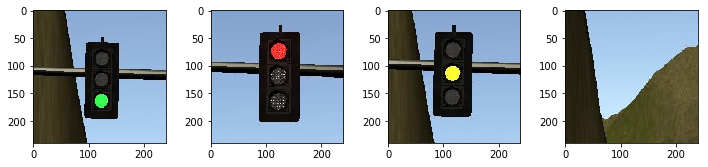

In [19]:
import glob

images = glob.glob('./training_data_simulator/test_cases/*-cut.jpg')

idx = 0
f, ax = plt.subplots(1,4, figsize=(10, 4))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    idx += 1

plt.show()

# Change color space

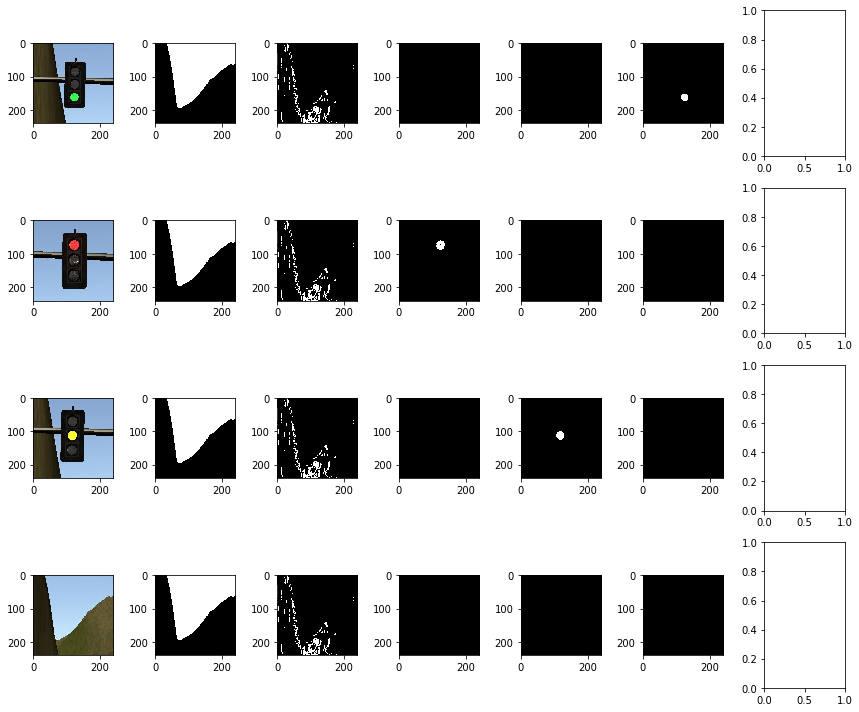

In [52]:
def get_is_mask(s_channel, v_channel):
    intensity_mask = cv2.inRange(v_channel, 160, 255)
    saturation_mask = cv2.inRange(s_channel, 160, 255)
    return intensity_mask & saturation_mask

def get_red_mask(h_channel):
    red_lower_mask = cv2.inRange(h_channel, 0, 10)
    red_upper_mask = cv2.inRange(h_channel, 170, 180)
    return red_lower_mask | red_upper_mask

def get_yellow_mask(h_channel):
    mask = cv2.inRange(h_channel, 20, 40)
    return mask

def get_green_mask(h_channel):
    mask = cv2.inRange(h_channel, 55, 75)
    return mask


idx = 0
f, ax = plt.subplots(4,7, figsize=(12, 10))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv_img[:,:,0]
    s = hsv_img[:,:,1]
    v = hsv_img[:,:,2]
    
    is_mask = get_is_mask(s,v)
    red_mask = get_red_mask(h)
    yellow_mask = get_yellow_mask(h)
    green_mask = get_green_mask(h)
        
    ax[idx, 1].imshow(intensity_mask,  cmap='gray')
    ax[idx, 2].imshow(saturation_mask,  cmap='gray')
    ax[idx, 3].imshow(red_mask & is_mask,  cmap='gray')
    ax[idx, 4].imshow(yellow_mask & is_mask,  cmap='gray')
    ax[idx, 5].imshow(green_mask & is_mask,  cmap='gray')
    
    idx += 1

plt.show()

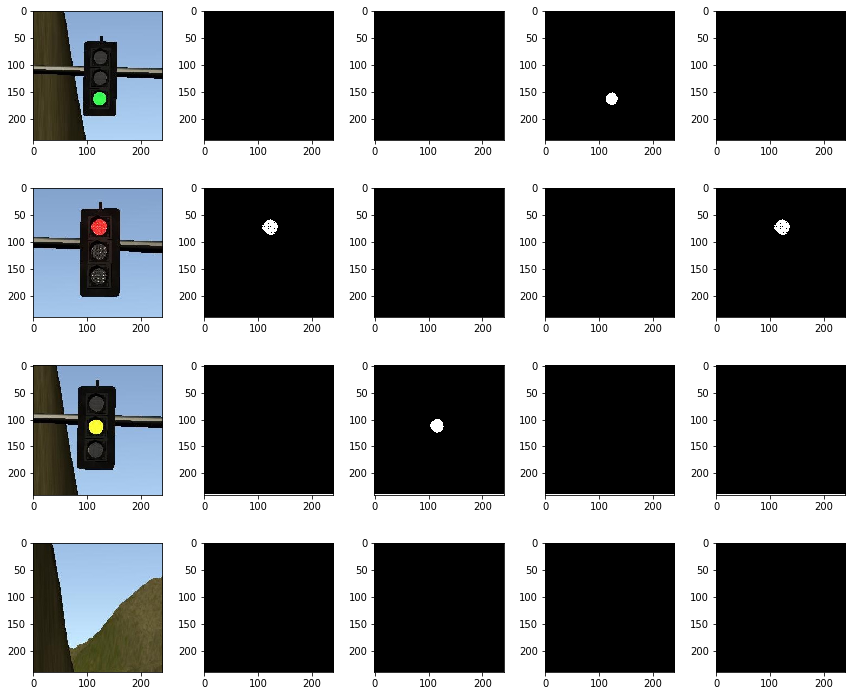

In [66]:
def find_circles(bw_image):
    img = bw_image # cv2.GaussianBlur(bw_image, (5, 5), 0)
    min_radius = bw_image.shape[0] / 200
    max_radius = bw_image.shape[0] / 30
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,
                               1,
                               minDist = int(min_radius * 2.5),
                               param1=100,
                               param2=50,
                               minRadius=int(min_radius),
                               maxRadius=int(max_radius))
                              
    return img

def find_red(hsv, img):
    red_lower_mask = cv2.inRange(hsv, (0,160,160), (10,255,255))
    red_upper_mask = cv2.inRange(hsv, (170,160,160), (180,255,255))
    return red_lower_mask | red_upper_mask

def find_yellow(hsv, img):
    return cv2.inRange(hsv, (20,160,160), (40, 255,255))

def find_green(hsv, img):
    return cv2.inRange(hsv, (55,160,160), (75, 255,255))
    return mask


idx = 0
f, ax = plt.subplots(4,5, figsize=(12, 10))
f.tight_layout()

for fname in images:
    img = cv2.imread(fname)
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv_img[:,:,0]
    s = hsv_img[:,:,1]
    v = hsv_img[:,:,2]
    
    r = find_red(hsv_img, img)
    y = find_yellow(hsv_img, img)
    g = find_green(hsv_img, img)
    
    ax[idx, 1].imshow(r,  cmap='gray')
    ax[idx, 2].imshow(y,  cmap='gray')
    ax[idx, 3].imshow(g,  cmap='gray')
    ax[idx, 4].imshow(find_circles(r),  cmap='gray')
    
    idx += 1

plt.show()